# Growth model

Here i simulate the basic growth model used by Charnov ect...

$$
\frac{dM}{dt} = aM^{\beta} - bM - cM^{\gamma}
$$

where $aM^{\beta}$ is energy intake with its mass scaling exponent, $bM$ is maintenece metabolism and $cM^{\gamma}$ is reproductive output.

the fitness ($R_0$) of an individual growing according to the model above can be obtained by integrating their reproductive output over time, including thier mortaility L(M):

$$
R_0 = \int_0^\infty cM^{\beta} L(M,t) dt
$$

This mortality function is set to an exponential decay function here:

$$
L(M,t) = e^{-\lambda Mt}
$$

where $\lambda$ is a rate parameter controling the rate at which the likelyhood of survival decreases.

I also consider the "switching on" of reproduction at some mass $M_{\alpha}$. This occurs instantly with a piecewise funtion for growth. 

In [75]:
using Pkg
# import Pkg; Pkg.add("DifferentialEquations")
# import Pkg; Pkg.add("DiffEqCallbacks")
# import Pkg; Pkg.add("Plots")
# Pkg.add("PGFPlots")
Pkg.activate("..")

using DifferentialEquations, DiffEqCallbacks, Plots, Printf

In [ ]:
# Pkg.rm("pgfplots")

In [3]:
function dM(dM,M,p,t)
    intak = p[:a_0] * (abs(M[1]) ^ p[:a_b])
    maint = p[:b_0] * (abs(M[1]) ^ p[:b_b])
    
#     if M[1] < p[:Ma] 
#         repro = 0.0
    if t < p[:Alph] 
        repro = 0.0
    else
        repro = p[:c_0] * (abs(M[1]) ^ p[:c_b])
        
        end
        
    dM[1] = intak - maint - repro
    dM[2] = repro * exp(-(p[:k]+p[:Z])*(t-p[:Alph]))
    
#     if M[1] + dM[1] < 0
#         dM[1] = -M[1]
#     end
    
end

dM (generic function with 1 method)

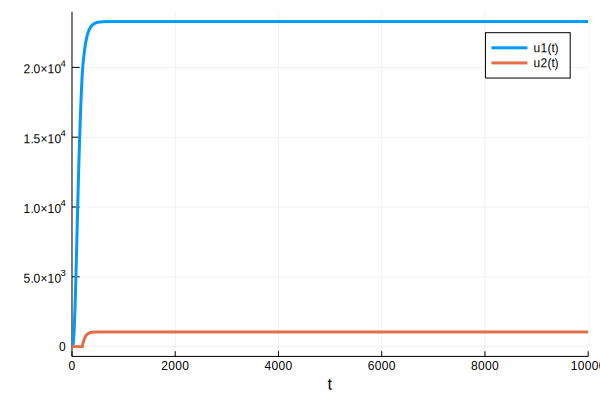

In [86]:
hypothetical_starting_mass = 0.1
hypothetical_asymptotic_mass = 25000
hypothetical_starting_reproduction = 0 #c * (hypothetical_starting_mass)^ rho
a = 0.7; a_b = 0.75
b = a/(hypothetical_asymptotic_mass^0.25)
c = 0.001 # West et al. assume 0.1 from Peters
alpha = 200
p = Dict([(:a_0,a),(:a_b,a_b),
          (:b_0,b),(:b_b,1.0),
          (:c_0,c),(:c_b,1.0),
          (:Alph,alpha),
          (:k,0.01),(:Z,2/alpha)])

M0 = [hypothetical_starting_mass, hypothetical_starting_reproduction]
# M0 = [1.,0.0]
tspan = (0.0,1e4)
prob = ODEProblem(dM,M0,tspan,p)
sol = solve(prob,Rosenbrock23())

# plot(hcat(sol.u...)')
plot(sol)

In [23]:
M_alph = sol(p[:Alph])[1]

19619.32028393124

In [ ]:
# sol.u

In [95]:
resolution = 100
c_vec = range(0.001,0.5,length = resolution)
c_b_vec = range(0.001,1.25,length = resolution)
results_no_shrink = Array{Float64,2}(undef,resolution,resolution)

tspan = (0.0,1e6)

for i in 1:resolution
    c_0 = c_vec[i]
    for j in 1:resolution
        c_b = c_b_vec[j]
        p = Dict([(:a_0,a),(:a_b,a_b),
          (:b_0,b),(:b_b,1.0),
          (:c_0,c_0),(:c_b,c_b),
          (:Alph,0.0),
          (:k,0.1),(:Z,0.9)])
        prob = ODEProblem(dM,M0,tspan,p)
        sol = solve(prob,Rosenbrock23())
        results_no_shrink[i,j] = sol[end][1]
    end
end

In [14]:
length(c_vec)

100

In [15]:
results

100×100 Array{Float64,2}:
 24999.9       24999.9       24999.9       …  13291.1      12473.5    
 24999.7       24999.7       24999.6           4301.26      3842.15   
 24999.5       24999.4       24999.3           2216.57      1960.12   
 24999.2       24999.1       24999.0           1374.7       1212.85   
 24999.0       24998.9       24998.7            944.1        833.216  
 24998.8       24998.6       24998.4       …    692.004      611.583  
 24998.5       24998.3       24998.1            530.773      469.971  
 24998.3       24998.1       24997.8            420.989      373.542  
 24998.1       24997.8       24997.5            342.649      304.691  
 24997.8       24997.5       24997.2            284.673      253.689  
 24997.6       24997.3       24996.9       …    240.496      214.782  
 24997.4       24997.0       24996.6            206.019      184.378  
 24997.1       24996.7       24996.3            178.569      160.14   
     ⋮                                     ⋱       

In [96]:
feas = results_no_shrink .> M_alph # matrix of feasible growth curves where asmyptotic size is larger than mass a maturity (i.e.) those curves with no shrinking

heatmap(feas, transpose=true) #, colormap=ColorMaps.Named("Jet"))
savefig("../Results/feasible.pdf") # Saves the plot from p as a .pdf vector graphic

In [97]:
results_optimisation = Array{Any,2}(undef,resolution,resolution)

M0 = [hypothetical_starting_mass, hypothetical_starting_reproduction]
tspan = (0.0,1e6)
# alpha=300
for i in 1:resolution
    c_0 = c_vec[i]
    for j in 1:resolution
        c_b = c_b_vec[j]
        p = Dict([(:a_0,a),(:a_b,a_b),
          (:b_0,b),(:b_b,1.0),
          (:c_0,c_0),(:c_b,c_b),
          (:Alph,alpha),
          (:k,0.01),(:Z,2/alpha)])
        prob = ODEProblem(dM,M0,tspan,p)
        sol = solve(prob,Rosenbrock23())
        results_optimisation[i,j] = sol
    end
end

In [99]:
x = [i.u[end][2] for i = results_optimisation]
max = findmax(x .* feas)
c_opt = c_vec[max[2][1]]
rho_opt = c_vec[max[2][2]]

heatmap(x .* feas, xlab="c", ylab="rho", transpose=true)
annotate!([(80, 90, text("c opt = $(@sprintf("%.2f", c_opt))\n  rho opt = $(@sprintf("%.2f", rho_opt))", 10, :white, :topright))])
# findmax(x .* feas) #, xlabel = "c value", ylabel = "rho value")
savefig("../Results/optimisation_heatmap_reg_intake.pdf") # Saves the plot from p as a .pdf vector graphic

43

In [77]:
print("c opt = ", c_vec[max[2][1]], "\nrho opt = ", c_b_vec[max[2][2]])

c opt = 0.3588686868686869
rho opt = 0.5308787878787878

In [ ]:
plot(hcat(results[19,20].(results[19,20], Val{1})...)')

In [ ]:
x = rand(12)

sqrt.(x)

In [ ]:
N_sim = 100
M_eq = 4000
results = Array{Float64,2}(undef,N_sim,N_sim)

a_vec = range(0,maximum(M_eq)+1,length = N_sim)

for i = 1:N_sim
    for j = 1:N_sim
        if a_vec[i] <= M_eq[j]
            p = Dict([(:a_0,1.0),(:a_b,.75),
              (:b_0,0.1),(:b_b,1.0),
              (:c_0,0.6),(:c_b,c_b_vec[j]),
              (:L,0.1),(:Ma,a_vec[i])])
            
            prob = ODEProblem(dM,M0,tspan,p)
            sol = solve(prob,AutoTsit5(Rosenbrock23()),callback = cb)
            
            results[i,j] = sol[2,end]
        else
            results[i,j] = 0.0
        end
        
    
    end
end

heatmap(c_b_vec,a_vec,results)